# Install and Import Necessary Dependencies

In [15]:
!pip install torch
!pip install transformers pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re

# Instantiate Model

In [17]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Load Data

Data obtained from https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch?resource=download





In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [19]:
import os
import pandas as pd

In [20]:
# Change to correct directory
try:
  os.chdir("/content/drive/MyDrive/Personal Projects/Suicide Detection Dataset")
  print('Directory change success')
except OSError:
  print('Directory change failed')

Directory change success


In [21]:
# Load dataset
df = pd.read_csv('Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


# Preprocess Data

Why? 🤔

Preprocessing standardizes the text so that computer models can better understand and work with human input. It also reduces computational complexity when model training. We want to avoid scenerios where words such as "Game" and "game" are counted as 2 different words.

Tasks:
- Fix spelling errors
- Change all letters to lowercase
- Remove stop words (words that do not contribute to the overall meaning of the text)
- Expand contractions (I've ➡ I have)
- Remove extra whitespaces
- Remove accents, URLs, symbols and digits




In [22]:
!pip install unidecode contractions pyspellchecker wordninja symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import numpy as np
import nltk
import unidecode
import contractions
import wordninja
import re
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from nltk.corpus import stopwords

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

In [34]:
# Defining preprocessing methods

# Spell check and change to lowercase with Symspell
def fix_spelling(text):
  suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
  corrected_text = suggestions[0].term
  return corrected_text

def remove_stop_words(text):
  stop_words = stopwords.words('english')
  selected_stop_words = [word for word in stop_words if word not in ['no', 'not', 'here', 'some']] # Keeping words that help to indicate suicidal ideation
  return ' '.join([word for word in text.split(' ') if word not in stop_words])

def remove_whitespace(text):
  text = text.strip()
  return ' '.join(text.split())

def expand_contractions(text):
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)

def remove_accents(text):
  return unidecode.unidecode(text)

def remove_urls(text):
  return re.sub(r'http\S+', '', text)

def remove_symbols_digits(text):
  return re.sub('[^a-zA-Z\s]', ' ', text)

def text_preprocessing(text):
  text = fix_spelling(text)
  text = remove_stop_words(text)
  text = remove_whitespace(text)
  text = expand_contractions(text)
  text = remove_accents(text)
  text = remove_urls(text)
  text = remove_symbols_digits(text)
  return text

# Preprocess all the data
df['cleaned_text'] = df['text'].apply(lambda row: text_preprocessing(row))
df[:10]

,Unnamed: 0,text,class,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left wife ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year e...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help i am crying hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,i am losthello name adam i have struggling ...
5,11,Honetly idkI dont know what im even doing here...,suicide,honetly idki do not know i am even feel like n...
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide,trigger warning excuse self inflicted burns kn...
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide,ends tonight cannot anymore quit
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,everyone wants edgy making self conscious feel...
9,18,My life is over at 20 years oldHello all. I am...,suicide,life years oldhello year old balding mal...


# Data Exploration



Tasks:
- Ngram exploration
- Wordcloud


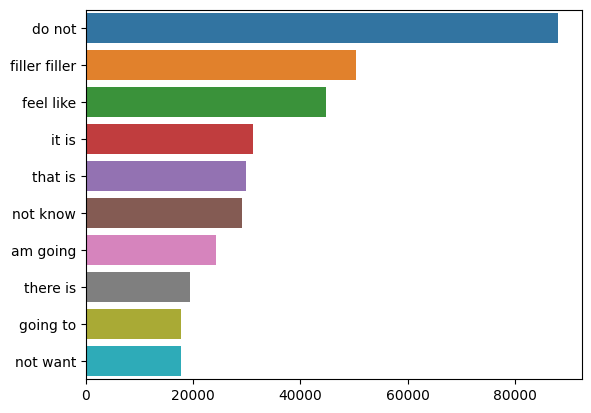

In [35]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

    
plot_top_ngrams_barchart(df['cleaned_text'],2)